# Model Training: Misinformation Classifier

This notebook focuses on training a multilingual BERT/RoBERTa model for misinformation detection. We will:

1. Load and prepare the preprocessed data
2. Set up the model architecture
3. Implement training and validation loops
4. Fine-tune the model
5. Evaluate performance
6. Save the trained model

## Setup and Dependencies

In [37]:
!pip install torchinfo

In [ ]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchinfo import summary

os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")

torch.manual_seed(42)
np.random.seed(42)


if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(42)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(42)
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [44]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Load and Prepare Data

First, we'll load our preprocessed training data and prepare it for the model.

In [ ]:
# Load the preprocessed training data

df = pd.read_csv("/content/balanced_data.csv")
print("Training data:",df.tail(20))
print("Length of the training data: ", len(df))

# Split into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].values,
    df['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# Initialized tokenizer (using XLM-RoBERTa for multilingual support)
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)


# ⚖️ Balanced speed/accuracy config
MAX_SEQ_LENGTH = 128  
MAX_TRAIN_SAMPLES =  None  
MAX_VAL_SAMPLES = None 

# Optimize CPU threading
torch.set_num_threads(min(4, os.cpu_count() or 4))

# Created a custom dataset class
class MisinformationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=MAX_SEQ_LENGTH):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]


        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Helper to downsample
rng = np.random.default_rng(42)

def downsample(texts, labels, max_samples):
    if max_samples is None or len(texts) <= max_samples:
        return texts, labels
    idx = rng.choice(len(texts), size=max_samples, replace=False)
    return texts[idx], labels[idx]

train_texts_ds, train_labels_ds = downsample(train_texts, train_labels, MAX_TRAIN_SAMPLES)
val_texts_ds, val_labels_ds = downsample(val_texts, val_labels, MAX_VAL_SAMPLES)

# Created datasets and dataloaders
train_dataset = MisinformationDataset(train_texts_ds, train_labels_ds, tokenizer, max_length=MAX_SEQ_LENGTH)
val_dataset = MisinformationDataset(val_texts_ds, val_labels_ds, tokenizer, max_length=MAX_SEQ_LENGTH)

# Printed a sample row of the dataset
print("SAMPLE ROW=====>")
print(train_dataset[0])


batch_size = 16  # Larger batch keeps steps low so epochs stay fast
num_workers = 4 
pin_memory = device.type == "cuda" 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

print(f"⚡ OPTIMIZED FOR SPEED:")
print(f"  Seq Length: {MAX_SEQ_LENGTH} ")
print(f"  Train Samples: {len(train_dataset)} ")
print(f"  Val Samples: {len(val_dataset)} ")
print(f"  Batch Size: {batch_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training data:                                                     text  label
10626  Kylie Jenner ‘Pleading’ With Travis Scott To D...      1
10627  Caitlyn Jenner Finally Ends Her Silence About ...      1
10628                 Ivanka Trump Us Weekly Cover Memes      1
10629  Alec, Hilaria Baldwin Introduce Baby Son Rafae...      1
10630  Bill Gates’ Former Doctor Says Billionaire ‘Re...      1
10631                   Selena Gomez Spies On The Weeknd      1
10632  Justin Bieber drives up to Selena Gomez's hous...      1
10633                                 Female First Forum      1
10634     Caitlyn Jenner Already Set For Second Boob Job      1
10635                      Fergie and Josh Duhamel split      1
10636  Adventure & Romance! Inside 95-Year-Old Betty ...      1
10637  Kris and Caitlyn Jenner Reportedly "Interact W...      1
10638  Celebrities React: Trump Withdraws Steph Curry...      1
10639  Justin Theroux flashes beard while with 'girlf...      1
10640  Victoria Beckham o

## 2. Model Setup and Training Functions

Now we'll set up the model architecture and define our training functions.

In [ ]:
import time
from transformers import AutoConfig
from tqdm.auto import tqdm

last_err = None
for attempt in range(3):
    try:
        # Loaded the configuration first to modify dropout
        config = AutoConfig.from_pretrained(model_name)
        config.attention_probs_dropout_prob = 0.2  
        config.hidden_dropout_prob = 0.2         
        config.num_labels=2
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            config=config,
            resume_download=True
        ).to(device)
        break
    except Exception as exc:
        last_err = exc
        wait_s = 5 * (attempt + 1)
        print(f"Encountered download issue ({exc}). Retrying in {wait_s}s... [{attempt + 1}/3]")
        time.sleep(wait_s)
else:
    raise RuntimeError("Failed to download model after multiple retries") from last_err

# Optimized: balanced LR + scheduler 
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01) 
num_epochs = 12 

total_training_steps = len(train_loader) * num_epochs
warmup_steps = max(1, int(0.2 * total_training_steps))
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps,
)

# Training function 
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    predictions, true_labels = [], []

    # Wrapped dataloader with tqdm
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        predictions.extend(outputs.logits.detach().argmax(dim=-1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        progress_bar.set_postfix({'loss': loss.item()}) 

    avg_loss = total_loss / max(1, len(dataloader))
    return avg_loss, predictions, true_labels

# Validation function 
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    predictions, true_labels = [], []

    with torch.no_grad():
        # Wrap dataloader with tqdm
        progress_bar = tqdm(dataloader, desc="Validation") # Added tqdm
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_loss += outputs.loss.item()
            predictions.extend(outputs.logits.detach().argmax(dim=-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            progress_bar.set_postfix({'loss': outputs.loss.item()}) # Update tqdm postfix with current loss

    avg_loss = total_loss / max(1, len(dataloader))
    return avg_loss, predictions, true_labels

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
summary(model)

Layer (type:depth-idx)                                            Param #
XLMRobertaForSequenceClassification                               --
├─XLMRobertaModel: 1-1                                            --
│    └─XLMRobertaEmbeddings: 2-1                                  --
│    │    └─Embedding: 3-1                                        192,001,536
│    │    └─Embedding: 3-2                                        394,752
│    │    └─Embedding: 3-3                                        768
│    │    └─LayerNorm: 3-4                                        1,536
│    │    └─Dropout: 3-5                                          --
│    └─XLMRobertaEncoder: 2-2                                     --
│    │    └─ModuleList: 3-6                                       85,054,464
├─XLMRobertaClassificationHead: 1-2                               --
│    └─Linear: 2-3                                                590,592
│    └─Dropout: 2-4                                               -

## 3. Train the Model

Now we'll train the model and track its performance.

In [ ]:

best_val_loss = float('inf')
train_losses, val_losses = [], []
start_time = time.time()
patience = 5

for epoch in tqdm(range(num_epochs)):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Training
    train_loss, train_preds, train_labels = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accuracy = np.mean(np.array(train_preds) == np.array(train_labels)) if train_preds else 0.0

    # Validation
    val_loss, val_preds, val_labels = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracy = np.mean(np.array(val_preds) == np.array(val_labels)) if val_preds else 0.0

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.3f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_accuracy:.3f}")
    print(f"Classification Report:\n{classification_report(val_labels, val_preds, zero_division=0)}")

    # Saved best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        model_save_path = os.path.join('best_model')
        model.save_pretrained(model_save_path)
        tokenizer.save_pretrained(model_save_path)
        print(f"✓ Saved best model")

    else:
        patience_counter += 1 # Increment counter if no improvement
        print(f"✗ Validation loss did not improve (Patience: {patience_counter}/{patience})")

    # Checked for early stopping
    if patience_counter >= patience:
        print(f"\nEARLY STOPPING triggered: Validation loss did not improve for {patience} epochs.")
        break

elapsed = time.time() - start_time
print(f"\n⚡ Total training time: {elapsed:.1f}s ({elapsed/60:.1f} min)")

  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 1/12


Training:   0%|          | 0/533 [00:00<?, ?it/s]

Validation:   0%|          | 0/134 [00:00<?, ?it/s]

Train Loss: 0.6667 | Train Acc: 0.582
Val Loss:   0.6124 | Val Acc:   0.706
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      1065
           1       0.70      0.73      0.71      1065

    accuracy                           0.71      2130
   macro avg       0.71      0.71      0.71      2130
weighted avg       0.71      0.71      0.71      2130

✓ Saved best model

Epoch 2/12


Training:   0%|          | 0/533 [00:00<?, ?it/s]

Validation:   0%|          | 0/134 [00:00<?, ?it/s]

Train Loss: 0.5796 | Train Acc: 0.714
Val Loss:   0.5532 | Val Acc:   0.741
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75      1065
           1       0.76      0.71      0.73      1065

    accuracy                           0.74      2130
   macro avg       0.74      0.74      0.74      2130
weighted avg       0.74      0.74      0.74      2130

✓ Saved best model

Epoch 3/12


Training:   0%|          | 0/533 [00:00<?, ?it/s]

Validation:   0%|          | 0/134 [00:00<?, ?it/s]

Train Loss: 0.5369 | Train Acc: 0.751
Val Loss:   0.5800 | Val Acc:   0.753
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.74      1065
           1       0.74      0.79      0.76      1065

    accuracy                           0.75      2130
   macro avg       0.75      0.75      0.75      2130
weighted avg       0.75      0.75      0.75      2130

✗ Validation loss did not improve (Patience: 1/5)

Epoch 4/12


Training:   0%|          | 0/533 [00:00<?, ?it/s]

Validation:   0%|          | 0/134 [00:00<?, ?it/s]

Train Loss: 0.4904 | Train Acc: 0.779
Val Loss:   0.5158 | Val Acc:   0.764
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      1065
           1       0.79      0.72      0.75      1065

    accuracy                           0.76      2130
   macro avg       0.77      0.76      0.76      2130
weighted avg       0.77      0.76      0.76      2130

✓ Saved best model

Epoch 5/12


Training:   0%|          | 0/533 [00:00<?, ?it/s]

Validation:   0%|          | 0/134 [00:00<?, ?it/s]

Train Loss: 0.4546 | Train Acc: 0.803
Val Loss:   0.5469 | Val Acc:   0.768
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.83      0.78      1065
           1       0.80      0.71      0.75      1065

    accuracy                           0.77      2130
   macro avg       0.77      0.77      0.77      2130
weighted avg       0.77      0.77      0.77      2130

✗ Validation loss did not improve (Patience: 1/5)

Epoch 6/12


Training:   0%|          | 0/533 [00:00<?, ?it/s]

Validation:   0%|          | 0/134 [00:00<?, ?it/s]

Train Loss: 0.4216 | Train Acc: 0.821
Val Loss:   0.5235 | Val Acc:   0.771
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1065
           1       0.79      0.74      0.76      1065

    accuracy                           0.77      2130
   macro avg       0.77      0.77      0.77      2130
weighted avg       0.77      0.77      0.77      2130

✗ Validation loss did not improve (Patience: 2/5)

Epoch 7/12


Training:   0%|          | 0/533 [00:00<?, ?it/s]

Validation:   0%|          | 0/134 [00:00<?, ?it/s]

Train Loss: 0.3676 | Train Acc: 0.845
Val Loss:   0.5168 | Val Acc:   0.773
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1065
           1       0.79      0.74      0.77      1065

    accuracy                           0.77      2130
   macro avg       0.77      0.77      0.77      2130
weighted avg       0.77      0.77      0.77      2130

✗ Validation loss did not improve (Patience: 3/5)

Epoch 8/12


Training:   0%|          | 0/533 [00:00<?, ?it/s]

Validation:   0%|          | 0/134 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa60b1ffec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa60b1ffec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.3378 | Train Acc: 0.866
Val Loss:   0.6066 | Val Acc:   0.773
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1065
           1       0.80      0.72      0.76      1065

    accuracy                           0.77      2130
   macro avg       0.78      0.77      0.77      2130
weighted avg       0.78      0.77      0.77      2130

✗ Validation loss did not improve (Patience: 4/5)

Epoch 9/12


Training:   0%|          | 0/533 [00:00<?, ?it/s]

Validation:   0%|          | 0/134 [00:00<?, ?it/s]

Train Loss: 0.3045 | Train Acc: 0.883
Val Loss:   0.6180 | Val Acc:   0.776
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78      1065
           1       0.78      0.77      0.77      1065

    accuracy                           0.78      2130
   macro avg       0.78      0.78      0.78      2130
weighted avg       0.78      0.78      0.78      2130

✗ Validation loss did not improve (Patience: 5/5)

🛑 EARLY STOPPING triggered: Validation loss did not improve for 5 epochs.

⚡ Total training time: 600.5s (10.0 min)


## 4. Visualize Training Results

Let's create some visualizations to analyze the model's performance.

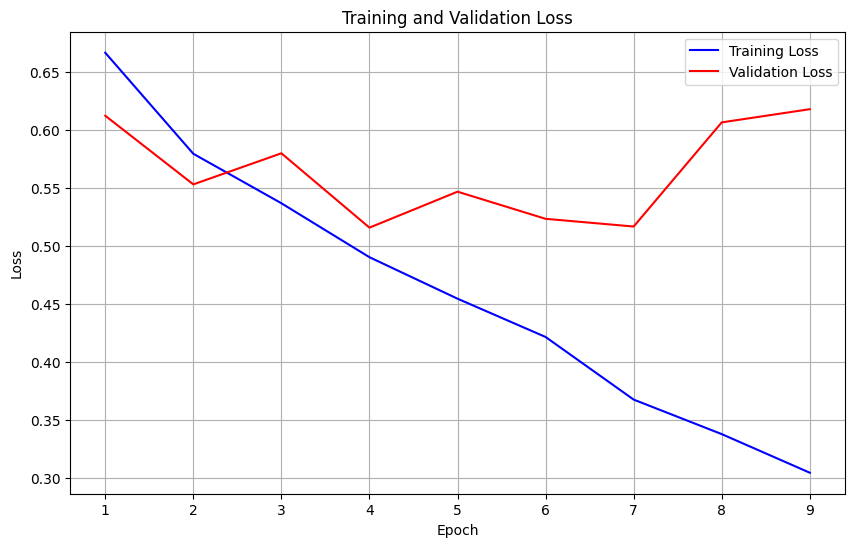

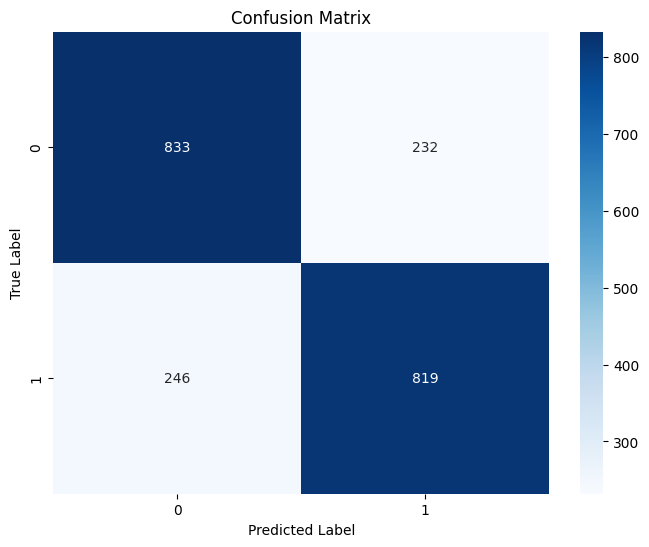

In [ ]:
# Plotted training and validation loss
plt.figure(figsize=(10, 6))
epochs_ran = range(1, len(train_losses) + 1)
plt.plot(epochs_ran, train_losses, 'b-', label='Training Loss')
plt.plot(epochs_ran, val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()